In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # to disable GPU
#import featureEng as fe
from ts_data.ts_data import ts_data as ts
import getStocks
import visualize
import ts_models.predicts
import pandas as pd
import ts_models.ts_lstm as ts_lstm

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

/home/ahendel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# view tenslow enabled devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12781453847436112310
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7930390119
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 7585110826776994029
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:17:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7728483533
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12455088207396650107
physical_device_desc: "device: 1, name: GeForce GTX 1070, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


# User parameters

In [3]:
ticker = 'amd'.upper()
n_in = 100 # number of historical days to input
n_out = 1 # days into future to predict
target = 'd1close'

# Load Data
### Several methods available here:
* Load a single stock
* get a refresh of the stock
* load a single stock as the target while using many other stocks as additional features

In [4]:
import imp
imp.reload(getStocks)

<module 'getStocks' from '/media/ahendel/Data/Dropbox/Projects/forecast-engine/src/getStocks.py'>

In [5]:
# load dataset
# dataset = getStocks.get_single(ticker=ticker, save=True)
# dataset = getStocks.load_single(ticker)
dataset = getStocks.join_tgt_spt(target_ticker=ticker.upper(), number_spt=20)
dataset.reset_index(level=0, inplace=True, drop=True)
dataset.rename(columns=lambda x: x.replace(' ',''),inplace=True)

In [6]:
dataset.head()

,Date,Open,High,Low,Close,AdjClose,Volume,MOpen,MHigh,MLow,MClose,MAdjClose,MVolume,HBIOpen,HBIHigh,HBILow,HBIClose,HBIAdjClose,HBIVolume,BKOpen,BKHigh,BKLow,BKClose,BKAdjClose,BKVolume,VIABOpen,VIABHigh,VIABLow,VIABClose,VIABAdjClose,VIABVolume,MGMOpen,MGMHigh,MGMLow,MGMClose,MGMAdjClose,MGMVolume,MTBOpen,MTBHigh,MTBLow,MTBClose,MTBAdjClose,MTBVolume,EMNOpen,EMNHigh,EMNLow,EMNClose,EMNAdjClose,EMNVolume,CELGOpen,CELGHigh,CELGLow,CELGClose,CELGAdjClose,CELGVolume,IPOpen,IPHigh,IPLow,IPClose,IPAdjClose,IPVolume,TXNOpen,TXNHigh,TXNLow,TXNClose,TXNAdjClose,TXNVolume,APCOpen,APCHigh,APCLow,APCClose,APCAdjClose,APCVolume,ULTAOpen,ULTAHigh,ULTALow,ULTAClose,ULTAAdjClose,ULTAVolume,HSICOpen,HSICHigh,HSICLow,HSICClose,HSICAdjClose,HSICVolume,DOpen,DHigh,DLow,DClose,DAdjClose,DVolume,ABCOpen,ABCHigh,ABCLow,ABCClose,ABCAdjClose,ABCVolume,COpen,CHigh,CLow,CClose,CAdjClose,CVolume,CTASOpen,CTASHigh,CTASLow,CTASClose,CTASAdjClose,CTASVolume,ACNOpen,ACNHigh,ACNLow,ACNClose,ACNAdjClose,ACNVolume,TROWOpen,TROWHigh,TROWLow,TROWClose,TROWAdjClose,TROWVolume,CTLOpen,CTLHigh,CTLLow,CTLClose,CTLAdjClose,CTLVolume
0,1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.153107,9.461292,9.122288,9.430473,1.792621,71700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1970-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.584566,9.861933,9.584566,9.769477,1.857062,118400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1970-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.769477,9.800296,9.615385,9.677022,1.839488,84300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1970-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.646203,9.646203,9.399654,9.461292,1.798479,93600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1970-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.492110,9.584566,9.492110,9.553747,1.816054,74200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare Data for LSTM

In [7]:
ts_data = ts(n_in=n_in, n_out=n_out, 
                      ticker=ticker,target=target,
                      rawData=dataset)
ts_data.eng_features(derivate=True, weekdays=False)
ts_data.roll_data()
ts_data.tscv(train=0.99)

/media/ahendel/Data/Dropbox/Projects/forecast-engine/src/ts_data/ts_data.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data.drop('Date', axis=1, inplace=True)


In [8]:
# using default options
'''
ts_data=ts_lstm.ts_data.default_prep(n_in=n_in, n_out=n_out, 
                      ticker=ticker,target=target,
                      rawData=dataset)


ts_data = ts_lstm.ts_data(n_in=n_in, n_out=n_out, 
                      ticker=ticker,target=target,
                      rawData=dataset)

ts_data.eng_features(derivate=True, weekdays=False)
ts_data.roll_data()
ts_data.tscv(train=0.99)
'''

'\nts_data=ts_lstm.ts_data.default_prep(n_in=n_in, n_out=n_out, \n                      ticker=ticker,target=target,\n                      rawData=dataset)\n\n\nts_data = ts_lstm.ts_data(n_in=n_in, n_out=n_out, \n                      ticker=ticker,target=target,\n                      rawData=dataset)\n\nts_data.eng_features(derivate=True, weekdays=False)\nts_data.roll_data()\nts_data.tscv(train=0.99)\n'

# Build LSTM Architecture

In [9]:
ts_model = ts_lstm.lstm_model(ts_data, 
                               inlayer=int(ts_data.train_X.shape[-1])*2,
                               hiddenlayers=0,
                               loss_function='mean_squared_error',
                               dropout=0.05,
                               activation='tanh')

Compilation Time :  0.012546300888061523
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 260)               406640    
_________________________________________________________________
dropout_1 (Dropout)          (None, 260)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 261       
Total params: 406,901
Trainable params: 406,901
Non-trainable params: 0
_________________________________________________________________


# Fit model

In [10]:
history = ts_model.fit(ts_data.train_X, ts_data.train_y, 
                    epochs=50, 
                    batch_size=1024, 
                    validation_data=(ts_data.test_X, ts_data.test_y), 
                    verbose=2, 
                    shuffle=False)

Train on 2435 samples, validate on 25 samples
Epoch 1/50
 - 2s - loss: 1.6944 - val_loss: 0.2323
Epoch 2/50
 - 1s - loss: 1.3935 - val_loss: 0.2799
Epoch 3/50
 - 1s - loss: 1.1454 - val_loss: 0.3327
Epoch 4/50
 - 1s - loss: 0.9424 - val_loss: 0.3844
Epoch 5/50
 - 1s - loss: 0.7643 - val_loss: 0.4296
Epoch 6/50
 - 1s - loss: 0.6227 - val_loss: 0.4642
Epoch 7/50
 - 1s - loss: 0.5262 - val_loss: 0.4873
Epoch 8/50
 - 1s - loss: 0.4433 - val_loss: 0.4979
Epoch 9/50
 - 1s - loss: 0.3824 - val_loss: 0.4968
Epoch 10/50
 - 1s - loss: 0.3286 - val_loss: 0.4860
Epoch 11/50
 - 1s - loss: 0.3033 - val_loss: 0.4676
Epoch 12/50
 - 1s - loss: 0.2832 - val_loss: 0.4435
Epoch 13/50
 - 1s - loss: 0.2687 - val_loss: 0.4160
Epoch 14/50
 - 1s - loss: 0.2512 - val_loss: 0.3875
Epoch 15/50
 - 1s - loss: 0.2385 - val_loss: 0.3596
Epoch 16/50
 - 1s - loss: 0.2353 - val_loss: 0.3336
Epoch 17/50
 - 1s - loss: 0.2274 - val_loss: 0.3106
Epoch 18/50
 - 1s - loss: 0.2207 - val_loss: 0.2907
Epoch 19/50
 - 1s - loss: 0

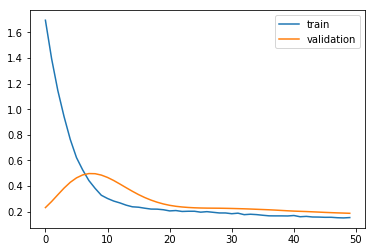

In [11]:
visualize.plot_loss(history)

# Results

In [12]:
# select last 30 days of test data (30 records)
n = 30
test_X = ts_data.test_X[-n:]
test_Y = ts_data.test_y[-n:]

In [13]:
test_Y[:,0]
# [print(x.shape) for x in test_X]

array([ 0.13 , -0.04 ,  0.06 , -0.03 ,  0.01 ,  0.17 , -0.38 , -0.34 ,
        0.06 , -0.16 , -0.7  , -0.12 ,  0.09 ,  0.04 , -0.1  ,  0.22 ,
       -0.26 ,  0.21 ,  0.02 ,  0.16 ,  0.69 , -0.03 ,  0.03 , -0.09 ,
       -0.445])

In [14]:
test_X.shape

(25, 100, 130)

In [15]:
yhat = [float(ts_model.predict(x.reshape(1, test_X.shape[-2], test_X.shape[-1]))) for x in test_X]

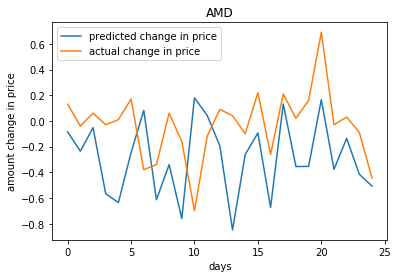

In [16]:
import matplotlib.pyplot as plt
x = [x for x in range(len(yhat))]
plt.plot(x, yhat, label='predicted change in price')
plt.plot(x, test_Y[:,0], label='actual change in price')
plt.title(ticker)
plt.xlabel('days')
plt.ylabel('amount change in price')
plt.legend()
plt.show()